<a href="https://colab.research.google.com/github/Parsa2820/50-years-lyrics/blob/master/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sharif University of Technology
Department of Computer Engineering

---
# Modern Information Retrieval Course
# **50 Years of the Best-Selling Music Artists Lyrics Comparison**
### Homework 2
### Dr. Asgari
### Parsa Mohammadian — 98102284
Spring 2022

---

## Introduction
The art of music play an important role in the human world. Besides the instrumental aspect, lyrics and content of a music are also important. In this project, I will explore and compare the lyrics of the best-selling music artists in a 50 years period (from 1969 to 2019). This list is taken from [Visual Capitalist](https://www.visualcapitalist.com/chart-toppers-50-years-of-the-best-selling-music-artists/) website. They have also visualized this data in an awesome [video](https://www.youtube.com/watch?v=a3w8I8boc_I). For the reference, I will use the image bellow to pick artist that has been top-selling for at least one consecutive year. Since the dataset is not provided, I have hardcoded the artists and their info in the code.

![top-seller-chart](../resources/top-sellers-chart.jpg)

> Because of the dataset size limit of this project, I have only used some of the artists with introduced conditions. So I commented out the other artist in the code. The 4 remaining artist datasets size is 4.89 MB.

Here is the list of what I want to do:

1. First I do some preprocessing of the data
2. Then I compare word frequency and profanity in the lyrics of the artists
3. Finally, I compare the lyrics of the artists visually in order to find similar artists

---

In [1]:
class Artist:
    def __init__(self, name: str, top_seller_begin_year: int, color: str):
        self.name: str = name
        self.top_seller_begin_year: int = top_seller_begin_year
        self.color: str = color
        self.lyrics: pd.DataFrame = None
        self.normalized_words_count: int = 0
        self.profanity_count: int = 0
        self.vocab: set = set()

    def __str__(self):
        return f'{self.name} ({self.top_seller_begin_year})'


artists = [
    Artist("The Beatles", 1969, "red"),
    # Artist("Elvis Presley", 1973, "blue"),
    Artist("Elton John", 1975, "green"),
    # Artist("Eagles", 1977, "yellow"),
    Artist("Michael Jackson", 1980, "orange"),
    # Artist("Madonna", 1985, "purple"),
    Artist("Eminem", 2001, "pink"),
    # Artist("Rihanna", 2008, "brown"),
    # Artist("Drake", 2013, "black")
]


## Required Libraries

---

In [ ]:
"""
Run this cell to install required python packages.
Skip if you have already installed following packages.
"""
%pip install better-profanity
%pip install matplotlib
%pip install nltk
%pip install pandas
%pip install tqdm
%pip install sentence_transformers
%pip install sklearn


In [3]:
import functools
import itertools
import math
import string

import better_profanity as bp
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')


## Dataset
The dataset consists of multiple csv files, each file named as "`<artist> Lyrics.csv`" and contains all songs of the artist with their lyrics. I have written the script in [dataset/lyrics-script](../datasets/lyrics-script/genius.py) to generate the dataset. In order to get lyrics, I used [Genius](https://genius.com/) API. It worths mentioning that the order of the songs in every file is according to the number of views of the song in Genius website.

---

In [5]:
"""
Load data
"""
DATA_FILE_PREFIX = "../datasets/"
DATA_FILE_SUFFIX = " Lyrics.csv"

for artist in tqdm.tqdm(artists):
    artist.lyrics = pd.read_csv(f"{DATA_FILE_PREFIX}{artist.name}{DATA_FILE_SUFFIX}")
    artist.lyrics.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
    artist.lyrics.set_index("idx", inplace=True)
    artist.lyrics.dropna(inplace=True)

for artist in artists:
    print(f"\n{artist.name} with {artist.lyrics.size} songs")
    print(artist.lyrics.head(1))


100%|██████████| 4/4 [00:00<00:00, 10.57it/s]


The Beatles with 1660 songs
     song_name                                        song_lyrics
idx                                                              
0    Let It Be  Let It Be Lyrics[Verse 1]\nWhen I find myself ...

Elton John with 1204 songs
     song_name                                        song_lyrics
idx                                                              
0    Your Song  Your Song Lyrics[Verse 1]\nIt's a little bit f...

Michael Jackson with 1384 songs
       song_name                                        song_lyrics
idx                                                                
0    Billie Jean  Billie Jean Lyrics[Verse 1]\nShe was more like...

Eminem with 1016 songs
    song_name                                        song_lyrics
idx                                                             
0     Rap God  Rap God Lyrics[Intro]\n"Look, I was gonna go e...


## Tokenization

---

In [6]:
for artist in artists:
    artist.lyrics["song_lyrics_tokenized"] = artist.lyrics["song_lyrics"].apply(lambda x: nltk.word_tokenize(x))


## Normalization

---

In [7]:
def to_lower(tokens: list) -> list:
    """
    Converts the tokens to lower case.
    """
    return [token.lower() for token in tokens]


def remove_lyrics_tags(tokens: list) -> list:
    """
    Removes the tags added by Genius from the lyrics. 
    For example, [Chorus], [Verse 1], ...
    """
    new_tokens = []
    tag = False
    for i in range(len(tokens)):
        if tokens[i] == '[':
            tag = True
        elif tokens[i] == ']':
            tag = False
        elif not tag:
            new_tokens.append(tokens[i])
    return new_tokens


def remove_song_name(tokens: list) -> list:
    """
    Removes the song name from the tokens.
    """
    keyword = "lyrics"
    if keyword in tokens:
        return tokens[tokens.index(keyword) + 1:]
    return tokens[:]


def contains_any_of(token: list, chars: str) -> bool:
    """
    Returns true if the token contains any of the characters in the given list.
    """
    return any(char in token for char in chars)


def remove_punctuation(tokens: list) -> list:
    """
    Removes punctuation from the given tokens.
    """
    return [token for token in tokens if not contains_any_of(token, string.punctuation+"’‘•")]


def remove_music_characters(tokens: list) -> list:
    """
    Removes ♪ characters from the given tokens.
    """
    return [token for token in tokens if not '♪' in token]


def remove_stop_words(tokens: list) -> list:
    """
    Removes stop words from the given tokens.
    """
    remove_stop_words.stop_words = set(nltk.corpus.stopwords.words('english'))
    with open("../resources/lyrics-stop-words", "r") as f:
        for line in f:
            remove_stop_words.stop_words.add(line.strip())
    return [token for token in tokens if token not in remove_stop_words.stop_words]


def normalize_lyrics(tokens):
    """
    Normalizes the tokens of the lyrics.
    """
    normalization_functions = [to_lower, remove_lyrics_tags, remove_music_characters,
                               remove_song_name, remove_punctuation, remove_stop_words]
    return functools.reduce(lambda x, f: f(x), normalization_functions, tokens)


In [8]:
for artist in artists:
    artist.lyrics["song_lyrics_normalized"] = artist.lyrics["song_lyrics_tokenized"].apply(normalize_lyrics)


## Stemming and Lemmatization

Here I have used Porter2 stemming algorithm to stem the words in the lyrics. The reason for preferring stemming over lemmatization is that it is more suitable for lyrics. We can see tons of examples in the lyrics which used ing form of the verb like "talkin" instead of "talking". In such a situation, the stemmer will remove suffix and leave the root word but lemmatization will not.

---

In [9]:
stemmer = nltk.stem.SnowballStemmer('english')

for artist in artists:
    artist.lyrics["song_lyrics_stemmed"] = (artist.lyrics["song_lyrics_normalized"].apply(lambda x: [stemmer.stem(t) for t in x]))


## Frequency Analysis and Find Stop Words

Although removing stop words was used in th normalization process, there are some extra worthless words in lyrics that we can determine by frequency analysis. So after the first frequency analysis, I gathered some other stop words in "`resources/lyrics-stop-words`" file and modified the normalization process to remove them.

> Keep in mind that tokens are stemmed, so it is possible to see misspelled words in the frequency analysis result.

---

In [10]:
for artist in artists:
    all_lyrics = itertools.chain(*artist.lyrics["song_lyrics_stemmed"])
    artist.freq_dist = nltk.FreqDist(all_lyrics)


In [11]:
freq_dist_dic = {}

for artist in artists:
    freq_dist = artist.freq_dist.most_common(20)
    freq_dist_profanity_filtered = []
    for word, count in freq_dist:
        freq_dist_profanity_filtered.append((bp.profanity.censor(word), count))
    freq_dist_dic[artist.name] = freq_dist_profanity_filtered

freq_dist_df = pd.DataFrame(freq_dist_dic)
freq_dist_df


,The Beatles,Elton John,Michael Jackson,Eminem
0,"(love, 1856)","(love, 960)","(love, 2928)","(like, 3070)"
1,"(know, 1587)","(like, 776)","(realli, 2380)","(get, 2242)"
2,"(get, 1119)","(know, 548)","(got, 1729)","(got, 1682)"
3,"(go, 1063)","(go, 547)","(babi, 1701)","(****, 1458)"
4,"(come, 954)","(time, 493)","(know, 1653)","(****, 1355)"
5,"(back, 888)","(never, 492)","(get, 1613)","(know, 1310)"
6,"(got, 877)","(got, 457)","(time, 1592)","(back, 1281)"
7,"(let, 851)","(get, 437)","(one, 1391)","(go, 1220)"
8,"(babi, 837)","(one, 404)","(bad, 1341)","(one, 1004)"
9,"(well, 709)","(see, 404)","(want, 1340)","(say, 900)"


## Profanity and Vocabulary  Analysis 

First I provide number (percent) of profanity words for each artist. Then I count each artists unique used words and by that I can see the vocabulary size of each artist.

---

In [12]:
for artist in artists:
    def count(tokens):
        artist.normalized_words_count += len(tokens)
        artist.vocab.update(tokens)
        for token in tokens:
            if bp.profanity.contains_profanity(token):
                artist.profanity_count += 1
    artist.lyrics["song_lyrics_stemmed"].apply(count)


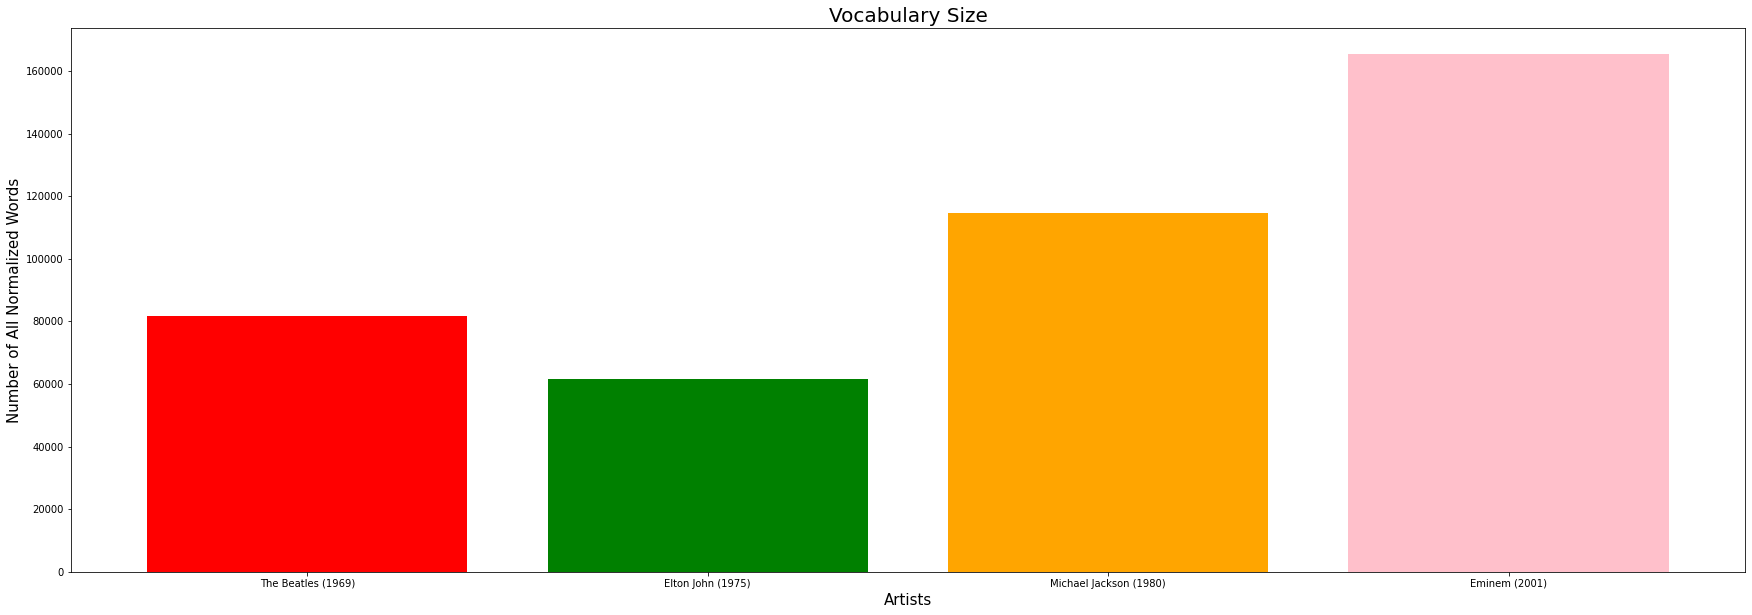

In [16]:
plt.figure(figsize=(30, 10))
plt.title("Vocabulary Size", fontsize=20)
plt.xlabel("Artists", fontsize=15)
plt.ylabel("Number of All Normalized Words", fontsize=15)
plt.bar(range(len(artists)), [artist.normalized_words_count for artist in artists], color=[artist.color for artist in artists])
plt.xticks(range(len(artists)), labels=[f"{artist}" for artist in artists])
plt.show()


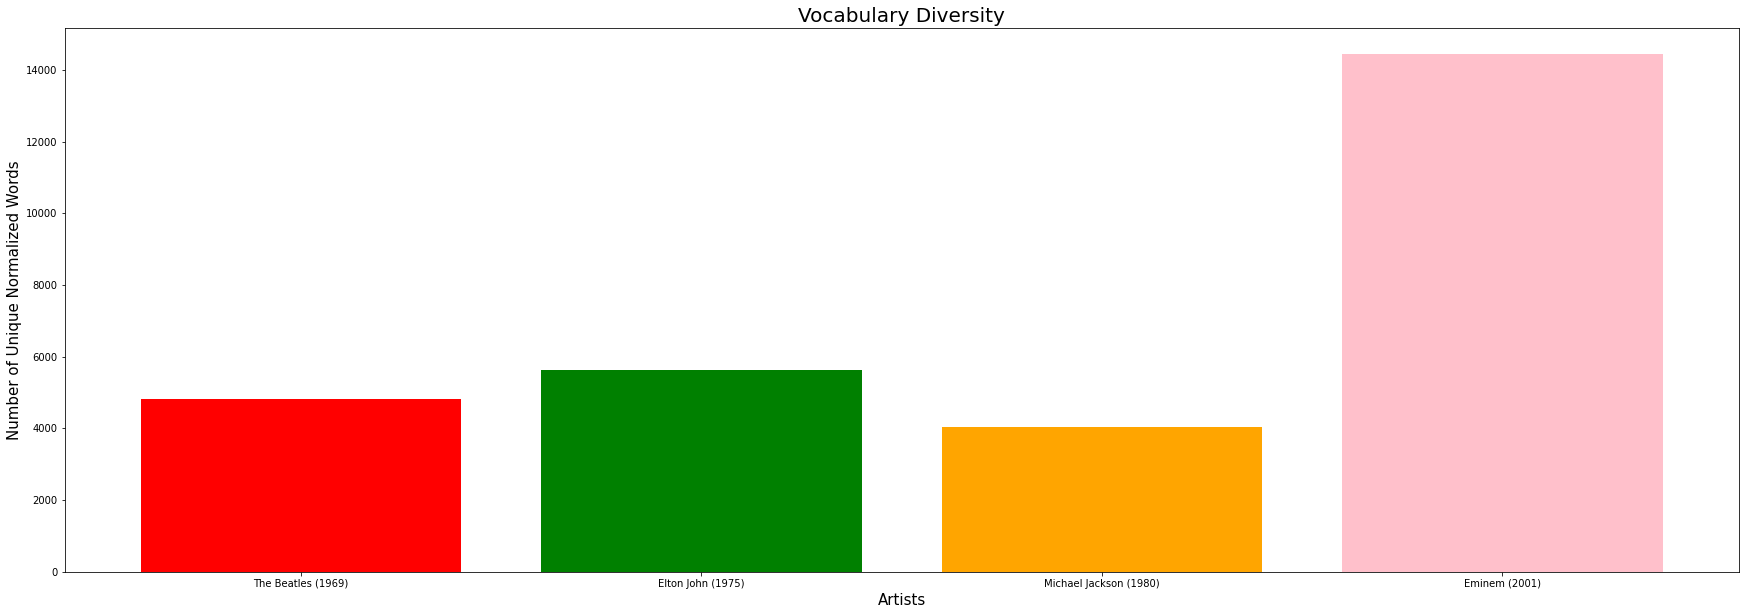

In [17]:
plt.figure(figsize=(30, 10))
plt.title("Vocabulary Diversity", fontsize=20)
plt.xlabel("Artists", fontsize=15)
plt.ylabel("Number of Unique Normalized Words", fontsize=15)
plt.bar(range(len(artists)), [len(artist.vocab) for artist in artists], color=[artist.color for artist in artists])
plt.xticks(range(len(artists)), labels=[f"{artist}" for artist in artists])
plt.show()


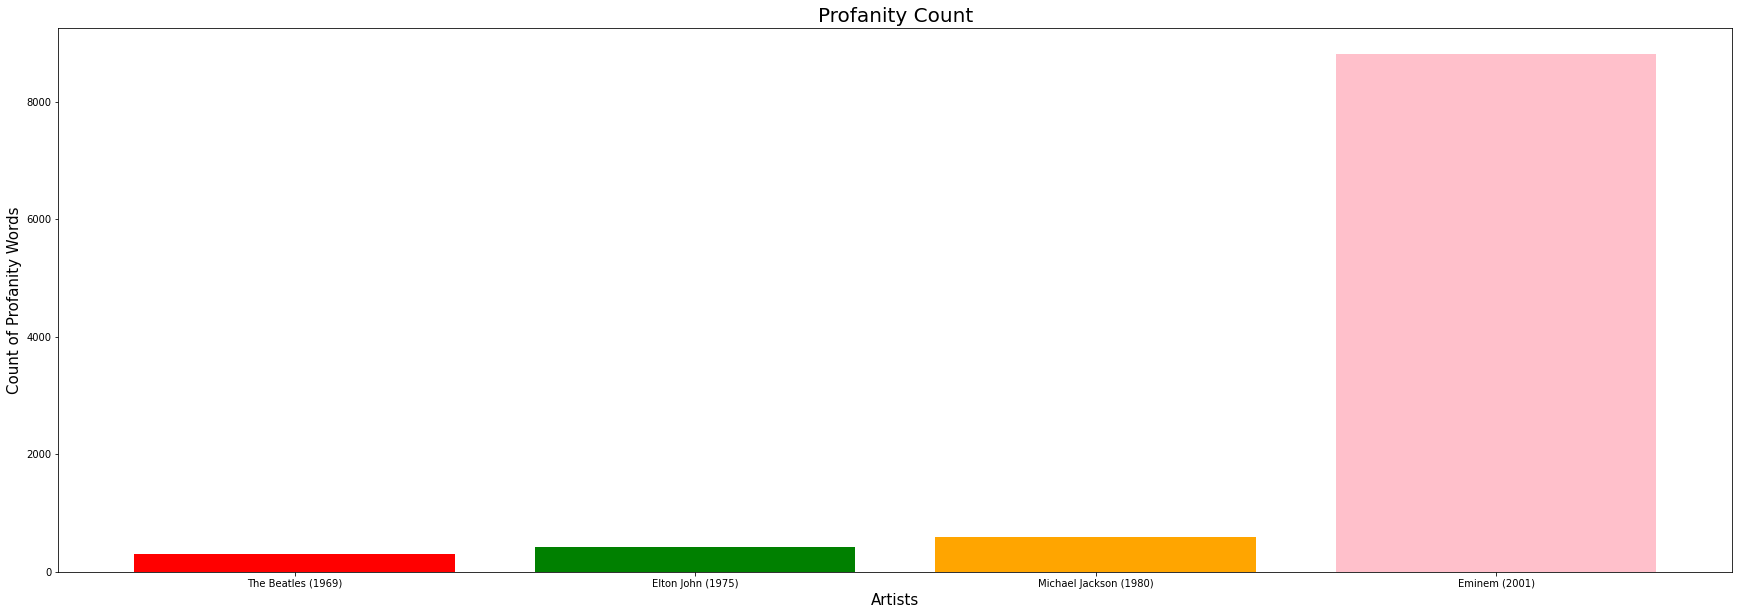

In [18]:
plt.figure(figsize=(30, 10))
plt.title("Profanity Count", fontsize=20)
plt.xlabel("Artists", fontsize=15)
plt.ylabel("Count of Profanity Words", fontsize=15)
plt.bar(range(len(artists)), [artist.profanity_count for artist in artists], color=[artist.color for artist in artists])
plt.xticks(range(len(artists)), labels=[f"{artist}" for artist in artists])
plt.show()


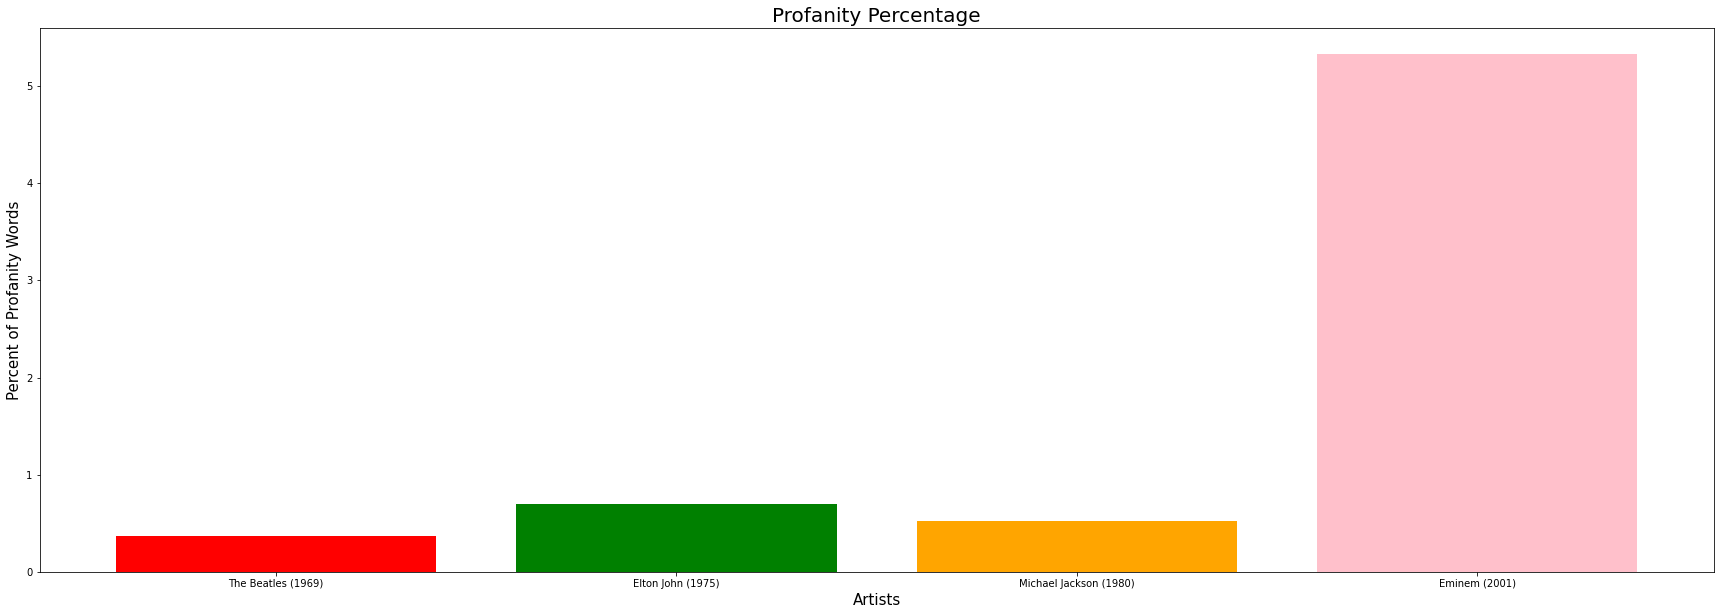

In [19]:
percent = lambda artist: artist.profanity_count / artist.normalized_words_count * 100
plt.figure(figsize=(30, 10))
plt.title("Profanity Percentage", fontsize=20)
plt.xlabel("Artists", fontsize=15)
plt.ylabel("Percent of Profanity Words", fontsize=15)
plt.bar(range(len(artists)), [percent(artist) for artist in artists], color=[artist.color for artist in artists])
plt.xticks(range(len(artists)), labels=[f"{artist}" for artist in artists])
plt.show()


As we can see in four above figures, the newer artists are using more diverse vocabulary. They also tend to use more profanity words.

## Visualize Lyrics!

This is the last part of the project. In this section, I want to vectorize the lyrics of each song to a vector of a fixed size which is 384. Then I merge all the lyrics into a matrix of size `(number of songs, vector size)`. After that I use a dimension reduction technique to reduce the dimension of the matrix to `(number of songs, 2)` which is the most suitable for visualization.

---

In [20]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
features = [f"feature_{i}" for i in range(384)]
song_vector_df = pd.DataFrame(columns=["artist"] + features)

for artist in artists:
    for song in tqdm.tqdm(artist.lyrics["song_lyrics_stemmed"], desc=f"{artist.name}"):
        song_str = " ".join(song)
        song_ds = pd.Series([artist.name] + list(model.encode(song_str)), index=song_vector_df.columns)
        song_vector_df = song_vector_df.append(song_ds, ignore_index=True)


Eminem: 100%|██████████| 508/508 [00:46<00:00, 11.01it/s]


In [21]:
x = StandardScaler().fit_transform(song_vector_df.loc[:, features])
y = song_vector_df.loc[:, ["artist"]]
pca = PCA(n_components=2)
pcs = pca.fit_transform(x)
pcs_df = pd.DataFrame(data = pcs, columns = ['pc1', 'pc2'])
song_two_vector_df = pd.concat([pcs_df, y], axis = 1)


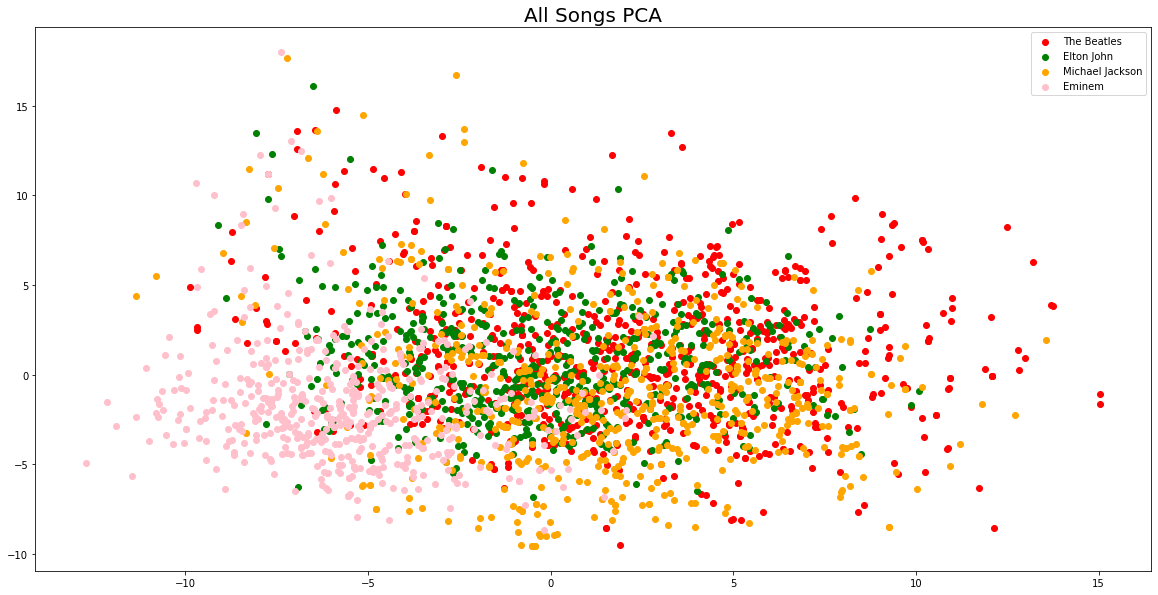

In [22]:
plt.figure(figsize=(20, 10))
plt.title("All Songs PCA", fontsize=20)
for artist in artists:
    songs = song_two_vector_df['artist'] == artist.name
    pc1 = song_two_vector_df[songs]['pc1']
    pc2 = song_two_vector_df[songs]['pc2']
    plt.scatter(pc1, pc2, c=artist.color)
plt.legend([artist.name for artist in artists]);


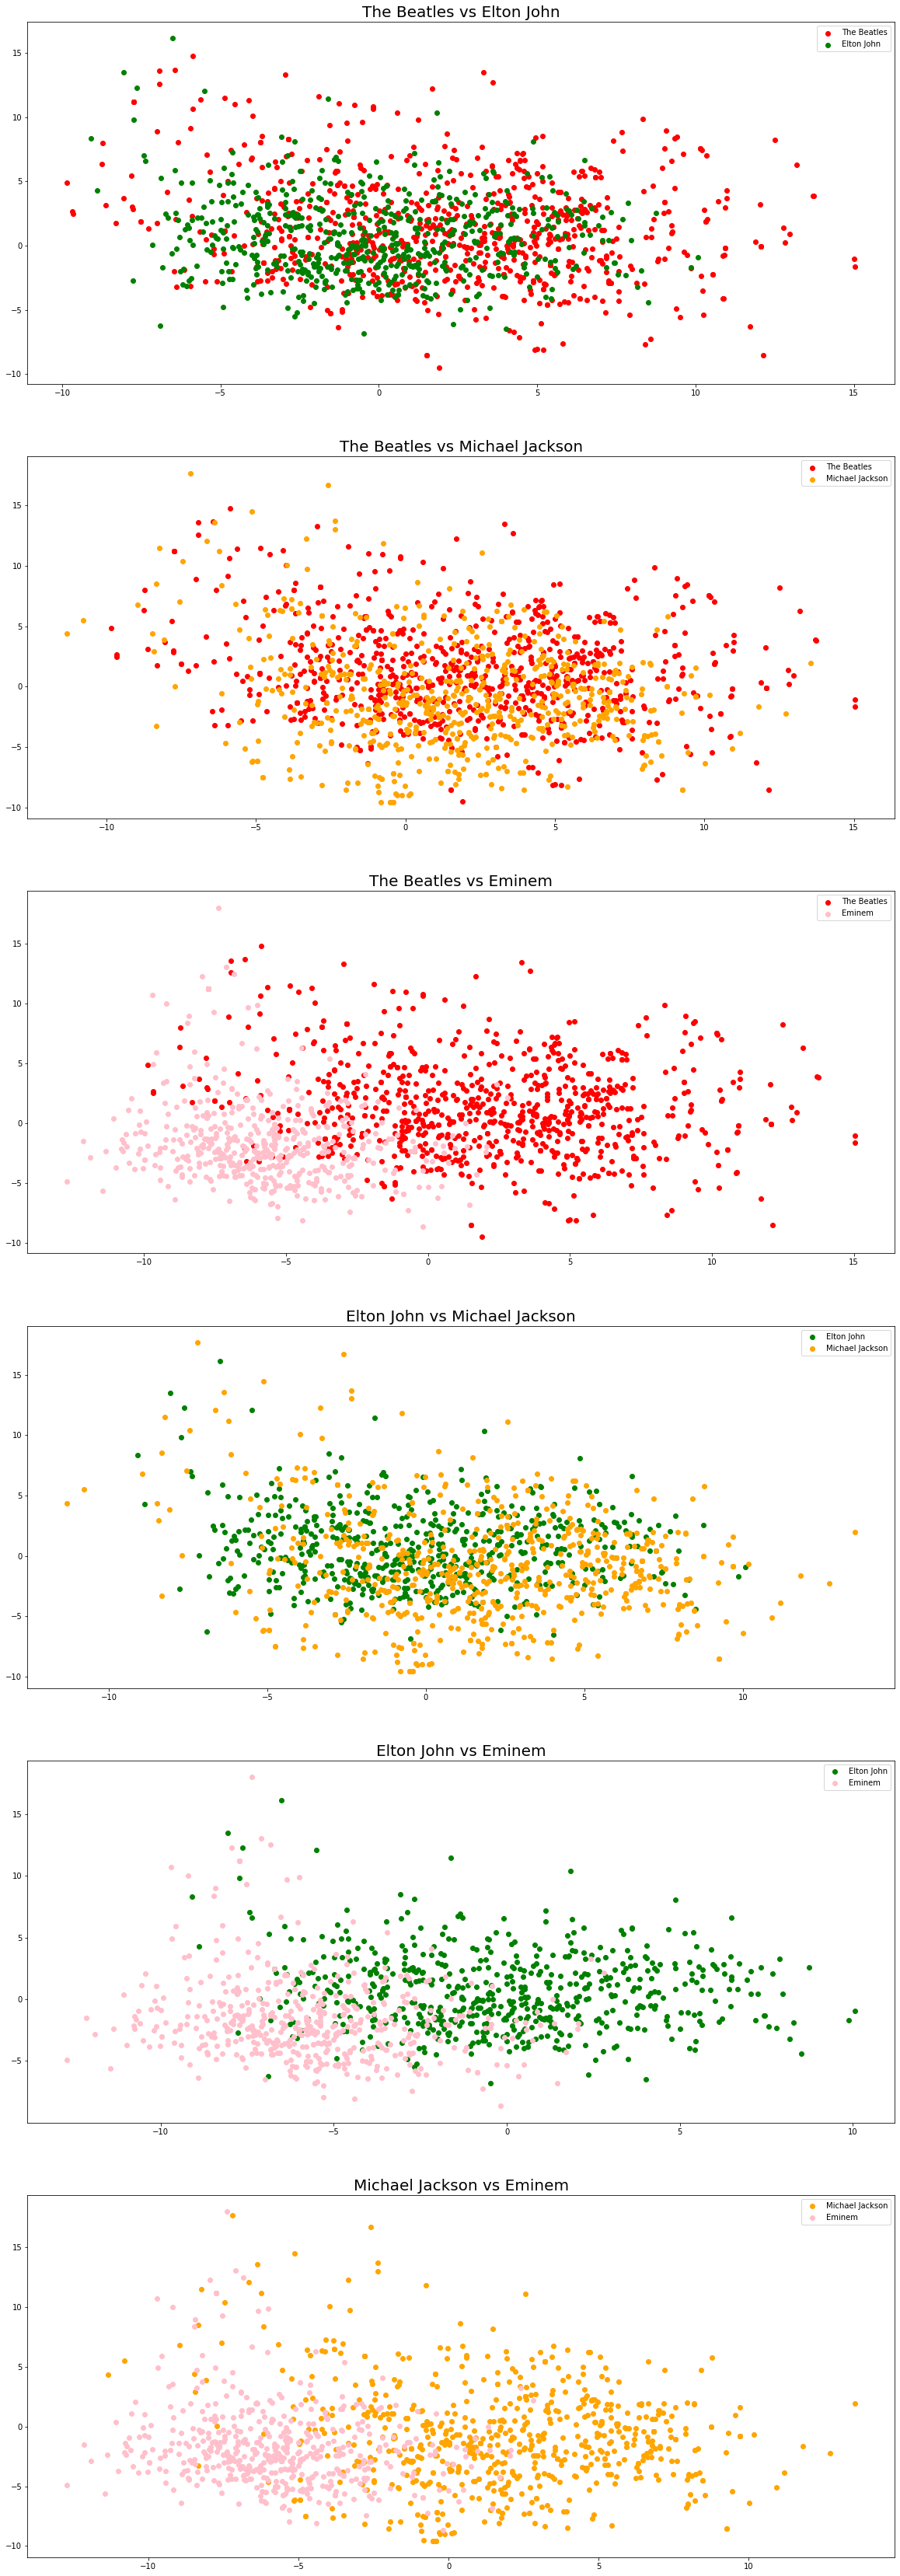

In [36]:
every_two_artists = list(itertools.combinations(artists, 2))
n = len(every_two_artists)
fig, ax = plt.subplots(n, 1, figsize=(20, 10*n))
idx = 0

for artist1, artist2 in every_two_artists:
    ax[idx].set_title(f"{artist1.name} vs {artist2.name}", fontsize=20)
    songs1 = song_two_vector_df['artist'] == artist1.name
    songs2 = song_two_vector_df['artist'] == artist2.name
    pc1 = song_two_vector_df[songs1]['pc1']
    pc2 = song_two_vector_df[songs1]['pc2']
    ax[idx].scatter(pc1, pc2, c=artist1.color)
    pc1 = song_two_vector_df[songs2]['pc1']
    pc2 = song_two_vector_df[songs2]['pc2']
    ax[idx].scatter(pc1, pc2, c=artist2.color)
    ax[idx].legend([artist1.name, artist2.name])
    idx += 1

plt.show()


As we can comprehend in the above figures, Eminem's lyrics are well-distinguishable from the rest of the artists and Elton John is the most similar artist to Eminem. The Beatles and Michael Jackson are so similar to each other; However, The Beatles's, Micheal Jackson's, and Elton John's lyrics are about the same.